<a href="https://colab.research.google.com/github/rifqoi/BERT-Sentiment-Analysis/blob/main/indoberttweetfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
!wget https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt -O stopword.txt
!wget https://cdn.discordapp.com/attachments/818681954303868938/995913295154393148/bismillah.json

--2022-07-12 09:05:41--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49923 (49K) [text/plain]
Saving to: ‘kamus_alay.csv’

kamus_alay.csv      100%[===================>]  48.75K  --.-KB/s    in 0s      

2022-07-12 09:05:42 (108 MB/s) - ‘kamus_alay.csv’ saved [49923/49923]

--2022-07-12 09:05:43--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 O

In [3]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 13.0 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=532877624f38a550901ba40eede523a0d797330422e4f121ff081812df6f0cb7
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 12.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 18.2 MB/s 
     |████████████████████████████████| 6.6 MB 46.3 MB/s 
     |████████████████████████████████| 596 kB 1.3 MB/s 
     |████████████████████████████████| 101 kB 6.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13


In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict
import string

# NLP
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

import tensorflow as tf

from transformers import TFBertForSequenceClassification, BertConfig, BertTokenizer, TFAutoModelForSequenceClassification, TFAutoModel
from transformers import InputExample, InputFeatures
import transformers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Import data
df = pd.read_json("bismillah.json")

In [6]:
df = df.sample(frac=1)

In [7]:
df = df[["tweets", "sentiment"]]
df

,tweets,sentiment
1148,"apalah prestasi anies di Jakarta ini, cuma sed...",Negative
1098,"Kalian belum lihat aja OK OCE mall, rumah DP 0...",Positive
3997,"Ya pak, formula e dan semua jenis trofi tidak ...",Neutral
4082,Pernahkah Anda dua kali jika saya tidak salah....,Neutral
1559,"Tolol, yg tdk setuju formula E dimonas siapa ?...",Positive
...,...,...
806,Awalnya ngributin mahoni Trus maksa2 spy ada u...,Negative
2358,"Proyeknya cuma trotoar, jpu, jis terakhir form...",Negative
3261,Formula E hanya mensejahterakan Bos formula e ...,Negative
2740,Cuma iblis yg gak mengakui kesuksesan Formula ...,Positive


Negative    1550
Positive    1338
Neutral     1286
Name: sentiment, dtype: int64


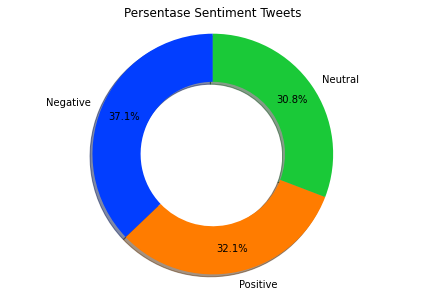

In [19]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()
# Plot arguments
sizes = df.sentiment.value_counts()
labels = ["Negative", "Positive", "Neutral"]
colors = sns.color_palette('bright')
explode = (0,0,0)

# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Persentase Sentiment Tweets')
print(sizes)

plt.show()


In [20]:
df.shape

(4174, 2)

In [7]:
df.tweets = df.tweets.apply(lambda x: x.lower())
df

,tweets,sentiment
507,anies baswedan gak perlu 5 tahun untuk hancurk...,Negative
1422,lebih kotor kalau balaan formula e di jakarta....,Negative
3298,"sukses besar, formula e jakarta terbaik sepanj...",Positive
1590,dalam pesan yang ditengarai sebagai hasil rapa...,Neutral
3882,"jika saya tidak salah, formula e di jakarta di...",Neutral
...,...,...
257,"menurut tgupp dki jakarta, pihak formula e ope...",Neutral
3029,panggung sandiwara jangan pada baper yg jelas ...,Positive
2590,mustinya ada agenda pembalap nginap di pulau s...,Neutral
1267,"ada kasus wadas, korupsi berderet yg blm tunta...",Negative


In [8]:
count = 0
for x in df.itertuples():
  if count == 10:
    break
  print(x.tweets)
  count += 1

anies baswedan gak perlu 5 tahun untuk hancurkan kota jakarta, dan berapa ratus miliar uang apbd dki yang di salah gunakan.... dengan istilah kelebihan bayar, proyek amburadul sumur resapan dan fee formula e  ??  koq ngana diem aja n gak berkicau  ??
lebih kotor kalau balaan formula e di jakarta.  soalnya sirkuitnya masih tanah
sukses besar, formula e jakarta terbaik sepanjang sejarah
dalam pesan yang ditengarai sebagai hasil rapat perhimpunan hotel dan restoran indonesia dengan pemda dan dinas pariwisata dki jakarta, disebutkan secara detail tingkatan serta harga tiket formula e jakarta. mulai dari 500.000 hingga 7.000.000 rupiah.
jika saya tidak salah, formula e di jakarta dijadwalkan pada 2 juni 2022. dalam waktu kurang dari 5 bulan, tuan. apakah anda yakin sirkuit dapat diselesaikan? 🤔
panitia penyelenggara formula e jakarta menepis mainan berupa mobil-mobilan dengan sampul wajah gubernur dki jakarta anies baswedan.
ya sudah kita lihat saja pagelaran formula e besok sperti apa, ban

In [9]:
def clean_data(x):
    x = x.lower()
    # Menghapus @username
    x = re.sub(r"@[A-Za-z0-9]\w+", "", x)  # Remove @
    # Menghapus link website
    x = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", x)  # Remove http links
    # Menghapus new line
    x = re.sub(r"\n", " ", x)
    # Menghapus whitespace pada sekitar kalimat
    x = x.strip()
    # Menghapus hashtag
    x = re.sub(r"\B(#\w+)+", r" ", x)
    # Mengubah % menjadi persen
    x = re.sub(r"(\d+) ?%", "\\1 persen", x)
    # Mengubah emoji menjadi kata 
    x = emoji.demojize(x, delimiters=(" ", " ")) 
    # Menghapus simbol-simbol
    x = re.sub(r"[^\w]", " ", x)
    # Menghapus huruf berulang 
    x = re.sub(r'(.)\1+', r'\1\1', x)     
    # Menghapus spasi berulang
    x = re.sub('\s+', ' ', x)

    return x


In [10]:
kamus_alay = pd.read_csv('kamus_alay.csv')

alay_word_dict = {}

for ele in kamus_alay.itertuples():
  alay_word_dict[ele.slang] = ele.formal

# Custom kata alay wokwokw
custom_word = {
    "bong": "cebong",
    "bongg": "cebong",
    "cebi": "cebong",
    "cebii": "cebong",
    "drun": "kadrun",
    "drunn": "kadrun",
    "druunn": "kadrun",
    "gabener": "gubernur",
    "gabenerr": "gubernur",
    "goodbener": "gubernur",
    "goodbenerr": "gubernur",
    "gotbener": "gubernur",
    "gub": "gubernur",
    "gutbener": "gubernur",
    "gutbenerr": "gubernur",
    "even": "event",
    "komitmen":  "commitment",
    "komitmenn":  "commitment",
    "komitmeen":  "commitment",
    "commitmentt": "commitment",
    "committmeentt": "commitment",
    "ayoo": "ayo",
    "ayok": "ayo",
    "ayook": "ayo",
    "ayokk": "ayo",
    "ayookk": "ayo",
    "kuy": "ayo",
    "kuyy": "ayo",
    "knapa": "kenapa",
    "knapaa": "kenapa",
    "knp": "kenapa",
    "knpa": "kenapa",
    "knpaa": "kenapa",
    "nggak": "enggak",
    "nggaak": "enggak",
    "nggakk": "enggak",
    "nggaakk": "enggak",
    "enggak": "enggak",
    "enggakk": "enggak",
    "enggaak": "enggak",
    "enggaakk": "enggak",
    "tidak": "enggak",
    "nis": "anies",
    "niss": "anies",
    "nies": "anies",
    "niess": "anies",
    "niies": "anies",
    "niiees": "anies",
    "niieess": "anies",
    "anis": "anies",
    "aniss": "anies",
    "aniis": "anies",
    "aniiss": "anies",
    "aniess": "anies",
    "aniiess": "anies",
}

alay_word_dict.update(custom_word)

def normalize_text(x):
  # Ubah kata alay menjadi formal
  x = [alay_word_dict[word] if word in alay_word_dict else word for word in x]

  return x


In [11]:
# Stopwords
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('indonesian'))

negation_words = ['tak', 'tidak', 'gak', 'enggak', 'nggak', 'jangan', 'bukan']
strong_words = ["sekali", 'sangat', 'terlalu', 'amat', 'benar', 'makin']
other_words = ["hari", "jauh", "siapa", "kenapa", "bagaimana", "dapat", "dapatkah", "apa", "kapan", "mengapa", ]
stopwords_to_remove = [negation_words, strong_words, other_words]

with open('./stopword.txt') as f:
  custom_stopwords = f.read().splitlines()

for words_list in stopwords_to_remove:
  for word in words_list:
    stopwords_list.discard(word)

def remove_stopwords(x):
  x = [word for word in x if word not in stopwords_list]
  return x

print(len(stopwords_list))
print(len(custom_stopwords))

737
357


In [12]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stemmer.stem("mengembalikan")
def stemming_text(x):
  x = [stemmer.stem(word) for word in x]
  return x

# df_stemmed = df_stripped_stopwords.copy()
# df_stemmed["tweets"] = df_stemmed.tweets.apply(stemming_text)
# df_stemmed

In [13]:
def preprocess_data(df, stem=False):
  df_processed = df.copy()
  df_processed.tweets = df_processed.tweets.apply(clean_data)
  df_processed.tweets = df_processed.tweets.apply(word_tokenize)
  df_processed.tweets = df_processed.tweets.apply(normalize_text)
  df_processed.tweets = df_processed.tweets.apply(remove_stopwords)
  if stem:
    df_processed.tweets = df_processed.tweets.apply(stemming_text)
  df_processed.tweets = df_processed.tweets.apply(lambda x: ' '.join(x))
  df_processed.sentiment = df_processed.sentiment.map({
    "Positive": 0,
    "Neutral": 1,
    "Negative": 2,
  })
  return df_processed

df_preprocessed = preprocess_data(df)
df_preprocessed

,tweets,sentiment
507,anies baswedan enggak 5 hancurkan kota jakarta...,2
1422,kotor balaan formula e jakarta sirkuitnya tanah,2
3298,sukses formula e jakarta terbaik sejarah,0
1590,pesan ditengarai hasil rapat perhimpunan hotel...,1
3882,enggak salah formula e jakarta dijadwalkan 2 j...,1
...,...,...
257,tgupp dki jakarta formula e operations feo mem...,1
3029,panggung sandiwara jangan bawa perasaan formul...,0
2590,mustinya agenda pembalap nginap pulau seribu t...,1
1267,wadas korupsi berderet tuntas kkn rezim partai...,2


In [14]:
def make_corpus(column):
    
    text_body = ""


    for sentences in column:
      sentences = sentences.split(' ')
      text_body += ' ' +' '.join(sentences)

    print(text_body)
    # transform list of words into 1 body of text
    corpus = re.sub('[ ]+',' ', text_body) # replace double whitespace with one
        
    return corpus

In [15]:
# Takes a while
corpus = make_corpus(df_preprocessed.tweets)

 anies baswedan enggak 5 hancurkan kota jakarta ratus miliar uang apbd dki salah istilah kelebihan bayar proyek amburadul sumur resapan fee formula e ngana diam n enggak berkicau kotor balaan formula e jakarta sirkuitnya tanah sukses formula e jakarta terbaik sejarah pesan ditengarai hasil rapat perhimpunan hotel restoran indonesia pemda dinas pariwisata dki jakarta detail tingkatan harga tiket formula e jakarta 500 00 7 00 00 rupiah enggak salah formula e jakarta dijadwalkan 2 juni 2022 5 tuan sirkuit dapat diselesaikan thinking_face panitia penyelenggara formula e jakarta menepis mainan mobil mobilan sampul wajah gubernur dki jakarta anies baswedan ya lihat pagelaran formula e besok apa enggak menonton berguna enggak rakyat jakarta we ll sih kpk berani bersikap adil amp independen temuan bpk dugaan korupsi era gubernur dki jakarta diselidiki jangan ajang balap formula e respon positif selidiki temuan bpk enggak tindak lanjuti topa pemenang tender formula e 60 persen saham dimiliki pt

In [16]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 9777


In [17]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 
    
    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [18]:
corpus_freq = word_freq(corpus, top=20)

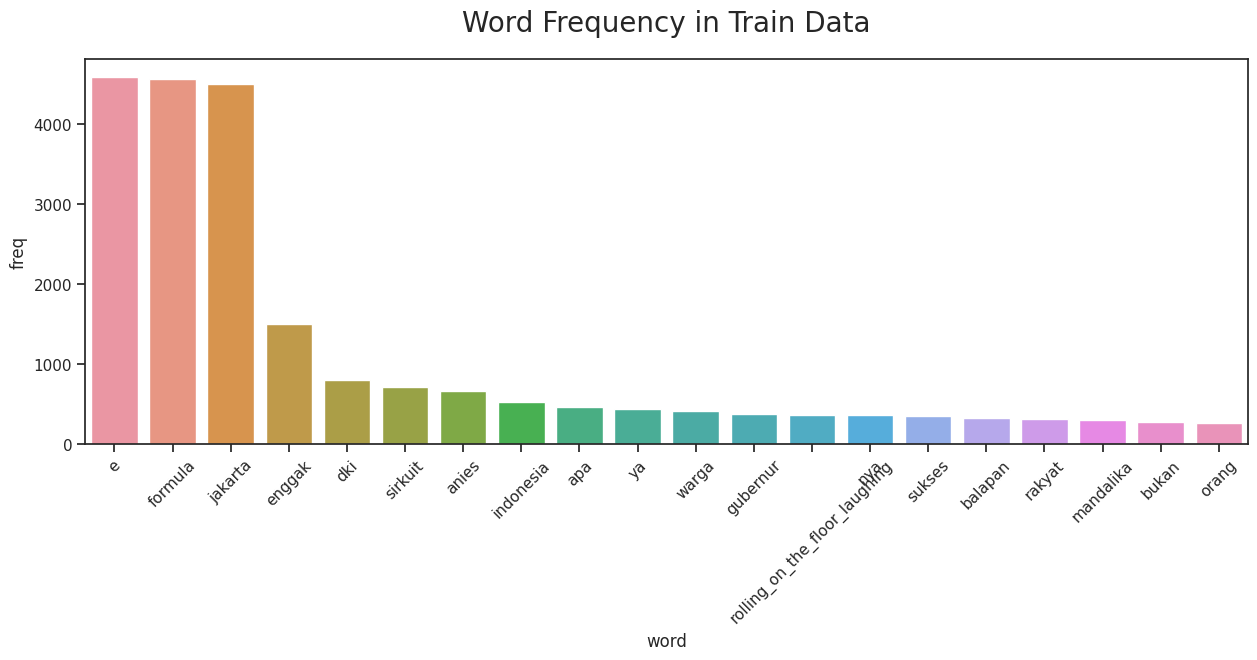

In [19]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

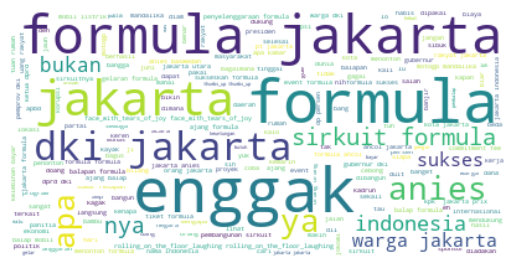

In [20]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [21]:
# train val split
train_set, val_set = train_test_split(df_preprocessed, test_size=0.2, stratify=df_preprocessed.sentiment)
val_set, test_set = train_test_split(val_set, test_size=0.5, shuffle=False)

In [22]:
def convert_data_to_examples(input_set,  DATA_COLUMN, LABEL_COLUMN):
  set_InputExamples = input_set.apply(lambda x: InputExample(guid=None,
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  return set_InputExamples


In [23]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length',
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [24]:
def convert_data_to_tf_dataset(train, val, data_column, label_column, tokenizer):
  train_InputExamples = convert_data_to_examples(train, data_column, label_column)
  validation_InputExamples = convert_data_to_examples(val, data_column, label_column)
  
  train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
  train_data = train_data.shuffle(100).batch(32).repeat(2)
  
  validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
  validation_data = validation_data.batch(32)
  return train_data, validation_data


In [25]:
def bert_model(pretrained_model, from_pt=False):
  tokenizer = BertTokenizer.from_pretrained(pretrained_model)
  config = BertConfig.from_pretrained(pretrained_model)
  config.labels = 3
  
  base_model = TFAutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=3, from_pt=from_pt)
  return base_model, tokenizer
model, tokenizer = bert_model('indolem/indobertweet-base-uncased', from_pt=True)

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
DATA_COLUMN = 'tweets'
LABEL_COLUMN = 'sentiment'

train_data, validation_data = convert_data_to_tf_dataset(train_set, val_set, DATA_COLUMN, LABEL_COLUMN, tokenizer)

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-6, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
210/210 [==============================] - 196s 820ms/step - loss: 0.9463 - accuracy: 0.5897 - val_loss: 0.7639 - val_accuracy: 0.7170
Epoch 2/7
210/210 [==============================] - 170s 808ms/step - loss: 0.7013 - accuracy: 0.7224 - val_loss: 0.6271 - val_accuracy: 0.7530
Epoch 3/7
210/210 [==============================] - 170s 807ms/step - loss: 0.5812 - accuracy: 0.7718 - val_loss: 0.5810 - val_accuracy: 0.7674
Epoch 4/7
210/210 [==============================] - 170s 809ms/step - loss: 0.4936 - accuracy: 0.8116 - val_loss: 0.5503 - val_accuracy: 0.7842
Epoch 5/7
210/210 [==============================] - 169s 807ms/step - loss: 0.4219 - accuracy: 0.8465 - val_loss: 0.5352 - val_accuracy: 0.7818
Epoch 6/7
210/210 [==============================] - 170s 808ms/step - loss: 0.3548 - accuracy: 0.8720 - val_loss: 0.5478 - val_accuracy: 0.7938
Epoch 7/7
210/210 [==============================] - 170s 808ms/step - loss: 0.2902 - accuracy: 0.9000 - val_loss: 0.5600 - val_ac

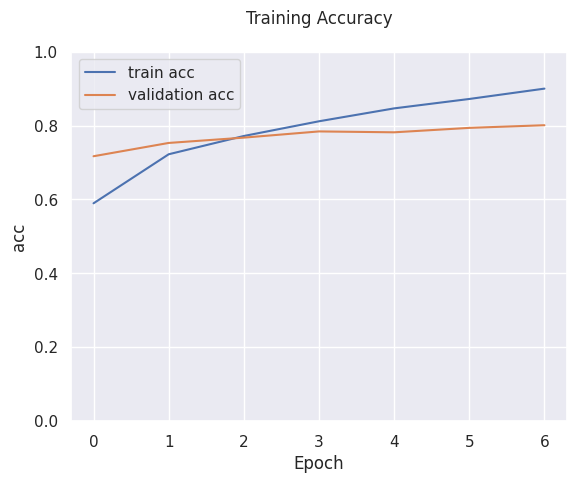

In [28]:
sns.set()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.title('Training Accuracy')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

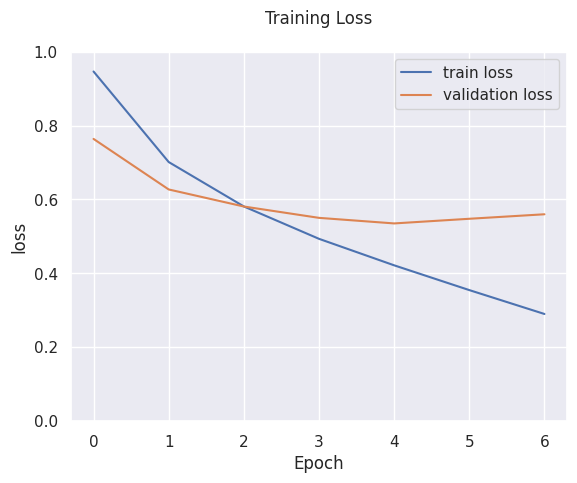

In [29]:
sns.set()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [30]:
test_sentences = list(test_set["tweets"])
tf_batch = tokenizer(test_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels =  ["Positive", "Neutral", "Negative"]
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
test_pred = []
for i in range(len(test_sentences)):
  test_pred.append(label[i])
print(test_pred)

[2, 2, 1, 1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 1, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 1, 1, 2, 2, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 2, 1, 0, 0, 1, 0, 2, 2, 1, 1, 1, 2, 0, 2, 2, 0, 1, 1, 2, 0, 1, 2, 0, 2, 2, 1, 2, 0, 1, 2, 1, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2, 2, 1, 2, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 1, 2, 0, 1, 1, 2, 2, 1, 0, 0, 1, 2, 0, 2, 2, 1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 0, 0, 2, 1, 0, 0, 2, 0, 1, 0, 1, 1, 1, 2, 2, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 2, 1, 2, 0, 1, 2, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 0, 1, 2, 2, 1, 1, 1, 2, 0, 0, 0, 1, 1, 2, 0, 0, 2, 0, 1, 2, 2, 1, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 1, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 1, 2, 2, 0, 1, 1, 

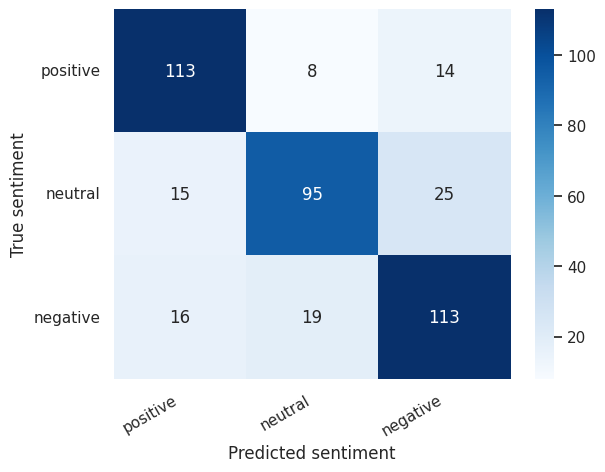

In [31]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(test_set.sentiment, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [32]:
print(classification_report(test_set.sentiment, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.78      0.84      0.81       135
     neutral       0.78      0.70      0.74       135
    negative       0.74      0.76      0.75       148

    accuracy                           0.77       418
   macro avg       0.77      0.77      0.77       418
weighted avg       0.77      0.77      0.77       418

